In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller # Test de Estacionariedad
from scipy.stats import ttest_ind # Prueba T de Student para comparación de medias
from scipy.stats import levene # Prueba Levente para comparación de varianzas
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit

import warnings
warnings.filterwarnings('ignore')

## 1. Análisis Exploratoio de Series de Tiempo

En esta exploración inicial buscamos lo siguiente:

- Graficar la serie (plot) → mirar si ves tendencias, estacionalidad, outliers.
- Describir: medias, varianzas, mínimos, máximos (describe()).
- Buscar missing values (isnull().sum()) y decidir la eliminación o imputación

In [217]:
data = pd.read_csv('dataset-registros.csv')
data = data[['cod_periodo','total_facturas']][data['cod_pais'].str.startswith('PE')].reset_index(drop=True).dropna(how='any')
data['fecha'] = pd.to_datetime(data['cod_periodo'],format='%Y%m%d')
data.head()

,cod_periodo,total_facturas,fecha
0,20210301,16679,2021-03-01
1,20210401,14311,2021-04-01
2,20210501,18695,2021-05-01
3,20210601,15876,2021-06-01
4,20210701,15265,2021-07-01


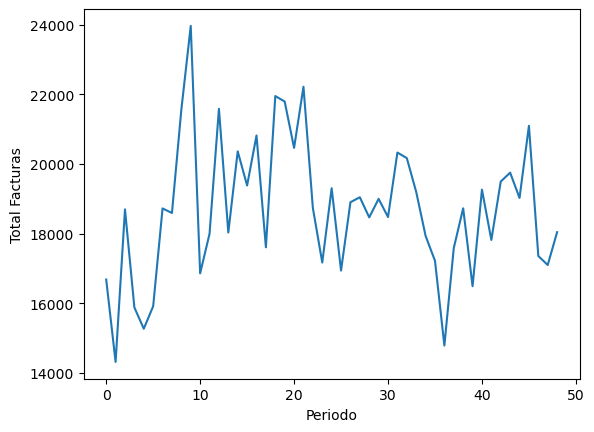

In [96]:
# Graficamos la serie
data['total_facturas'].plot()
plt.xlabel('Periodo')
plt.ylabel('Total Facturas')
plt.show()

In [97]:
# Describir la serie de tiempo
data['total_facturas'].describe()

count       49.000000
mean     18694.897959
std       2006.039249
min      14311.000000
25%      17355.000000
50%      18723.000000
75%      19751.000000
max      23969.000000
Name: total_facturas, dtype: float64

In [98]:
#Coeficiente de variación
coef_var = data['total_facturas'].std() / data['total_facturas'].mean()
print('Coeficiente de Variación:',coef_var)

Coeficiente de Variación: 0.1073041026156968


In [99]:
# Datos Faltantes
data['total_facturas'].isnull().sum()

0

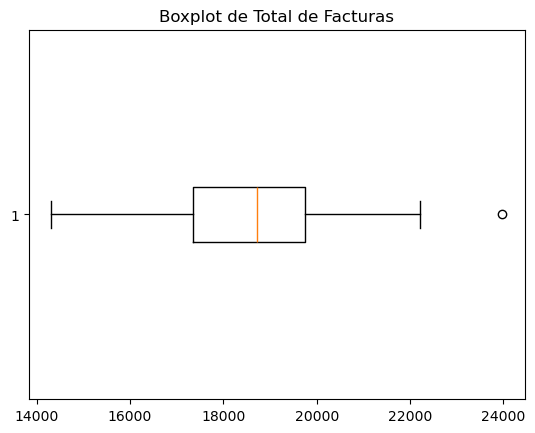

In [102]:
# Outliers
plt.boxplot(data['total_facturas'],vert=False)
plt.title('Boxplot de Total de Facturas')
plt.show()

In [103]:
def identificar_outliers(serie):

    Q1 = serie.quantile(0.25)
    Q3 = serie.quantile(0.75)

    IQR = Q3 - Q1

    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    return serie[(serie < limite_inferior) | (serie > limite_superior)]

In [104]:
identificar_outliers(serie=data['total_facturas'])

9    23969
Name: total_facturas, dtype: int64

In [105]:
data[data.index==9]

,cod_periodo,total_facturas
9,20211201,23969


- Contamos con 49 periodos (mensuales)
- La media está alrededor de 18694 facturas mensuales
- Se puede apreciar una desviación estánddar de 2006.
- El coeficiente de variación es de 10.73%. Se considera que un coeficiente de variación entre 10 y 15% es bajo (distribución homogénea). Coeficientes superiores al 20% se consideran distribuciones con alta dispersión, por lo que nuestra serie de tiempo tiene una **baja variabilidad** respecto a la media.
- No tenemos valores faltantes
- Se puede ver que los valores históricos han registrado mínimos de 14311 y unos máximos de 23969
- Se puede apreciar un único outlier en el periodo **Diciembre 2021**, el cual tiene un valor de 23969

## 2. Revisión de Estacionariedad

En esta etapa, lo que se busca es detectar si nuestra serie es estacionaria. Es importante que esto sea así porque hay modelos que asumen **estacionariedad**

🧪 Test ADF (adfuller) para saber si la serie es estacionaria:

- Si p-valor < 0.05 → estacionaria ✅
- Si p-valor > 0.05 → no estacionaria ❌

📈 Graficar ACF/PACF:

- Ver si las autocorrelaciones bajan rápido (propio de estacionarias).
- Estudiar comportamiento para pensar en AR (PACF) o MA (ACF).

## 2.1. Test ADF (ADFuller)

El **Test ADF (Augmented Dickey-Fuller Test)** nos permite identificar si una serie es estacionaria o no, para esto, se plantea una prueba de hipótesis donde de busca validar si hay raíz unitaria.

Ahora, **¿Qué es una raíz unitaria?**

Es una propiedad de una serie de tiempo donde el valor actual depende completamente de su valor pasado + un error aleatorio.

**¿Por qué no queremos raíz unitaria?**

- Porque si hay raíz unitaria, no puedes confiar en que la serie se mantenga estable en el tiempo.
- Una serie con raíz unitaria no tiene memoria corta: cualquier shock, error o cambio nunca desaparece, se arrastra para siempre.

Un ejemplo de raíz unitaria: 

- Imagínate que tu serie es el precio de una acción.
- Un rumor falso hace que el precio suba.
- Si la acción tiene raíz unitaria, ese precio alto se queda para siempre (aunque el rumor sea mentira).
- Si no hay raíz unitaria, el precio eventualmente vuelve a su tendencia normal.

Tomando eso en consideración, para nuestro Test ADF,:

- **Hipótesis Nula**: Sí hay raíz unitaria -> La serie de tiempo no es estacionaria
- **Hipótesis Alterna**: No hay raíz unitaria -> La serie de tiempo es estacionaria

Valores menores a 0.05 caen en la **zona de rechazo a la hipótesis nula**, por lo que tenemos evidencia suficiente de que nuestra serie **es estacionaria**

In [118]:
resultado_adf = adfuller(data['total_facturas'])

# Extraer estadísticas
estadistico_adf = resultado_adf[0]
p_valor = resultado_adf[1]

# Imprimir resultados
print(f"Estadístico ADF: {estadistico_adf:.4f}")
print(f"Valor-p: {p_valor:.4f}\n")

# Interpretación
if p_valor < 0.05:
    print("✅ El valor-p es menor a 0.05. Rechazamos la hipótesis nula.")
    print("Conclusión: La serie es estacionaria (no tiene raíz unitaria).")
else:
    print("❌ El valor-p es mayor a 0.05. No rechazamos la hipótesis nula.")
    print("Conclusión: La serie no es estacionaria (tiene raíz unitaria).")

Estadístico ADF: -5.0102
Valor-p: 0.0000

✅ El valor-p es menor a 0.05. Rechazamos la hipótesis nula.
Conclusión: La serie es estacionaria (no tiene raíz unitaria).


Si la serie no fuera estacionaria en primera instancia, podríamos intentar **diferenciando** la serie.

**Diferenciar** implica generar una serie de tiempo que sería una diferencia entre el periodo actual con el periodo anterior.

¡OJO! En la medida de lo posible, hay que evitar diferenciar la serie o, de ser necesario, hacerlo lo menos posible. ¿Por qué?

- Estás "quitándole" parte de su estructura original.
- Pierdes información sobre niveles reales (por ejemplo, el valor de las ventas, no solo su cambio).

Si diferencias muchas veces, puedes sobrediferenciar la serie, lo cual:
- Introduce ruido y haces que los errores se amplifiquen.
- Además, puede dificultar la interpretación del modelo.

In [113]:
# Generar diferenciación de nivel 1
data['dif1'] = data['total_facturas'].diff(1)
data.head()

,cod_periodo,total_facturas,dif1
0,20210301,16679,NaN
1,20210401,14311,-2368.0
2,20210501,18695,4384.0
3,20210601,15876,-2819.0
4,20210701,15265,-611.0


In [120]:
# Generar serie del dif1 sin nulos. Como el primer valor no tiene con qué compararse, quedará como NaN, y no se pueden aplicar test a valores nulos
dif1 = data['dif1'].dropna()
dif1.head()

1   -2368.0
2    4384.0
3   -2819.0
4    -611.0
5     645.0
Name: dif1, dtype: float64

## 2.2. Gráficas ACF y PACF

Las gráficas ACF (Autocorrelación) y PACF (Autocorrelación Parcial) son gráficas que nos permiten medir el grado de autocorrelación de un periodo con periodos anteriores.

- **ACF** mide toda la autocorrelación directa e indirecta. Sirve para identificar efectos de **medias móviles (MA)**.
- **PACF** mide solo la autocorrelación directa de un lag específico (filtrando el efecto de los intermedios). Ideal para identificar **componentes autoregresivos (AR)**.

Cuando queremos utilizar modelos AR o MA, u otros modelos que integran ambos (como ARIMA o SARIMAX), tomamos en cuenta lo siguiente.

- En ACF: el primer corte ayuda a sugerir el orden del modelo MA(q).
- En PACF: el primer corte ayuda a sugerir el orden del modelo AR(p).

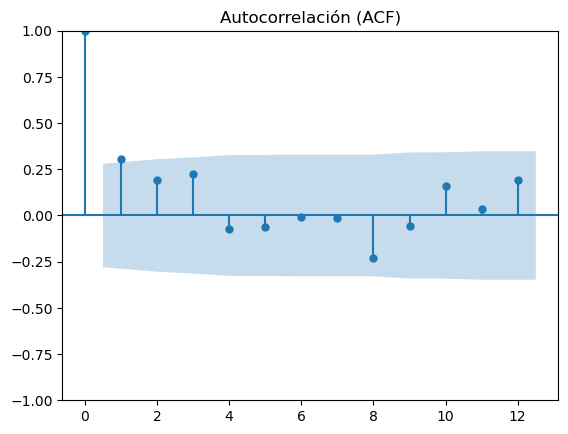

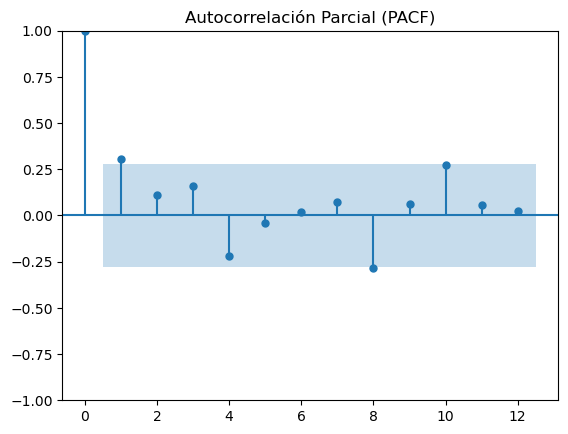

In [123]:
# Graficar la autocorrelación (ACF)
plot_acf(data['total_facturas'], lags=12) # Se toma 12 para ver estacionalidad anual
plt.title('Autocorrelación (ACF)')
plt.show()

# Graficar la autocorrelación (ACF)
plot_pacf(data['total_facturas'], lags=12) # Se toma 12 para ver estacionalidad anual
plt.title('Autocorrelación Parcial (PACF)')
plt.show()

### 2.2.1. Interpretación

Esta gráfica nos dice el nivel de Autocorrelación (ACF) ideal para modelos (MA - Moving Average) y Autocorrelación Parcial (PACF) para modelos (AR - Modelos Autoregresivos)

Es importante tomar lo siguiente en cuenta:
- El primer lag (0) <u>siempre será 1</u>, porque está correlacionado consigo mismo.
- El resto de lags son los demás periodos e indican cuánta autocorrelación tiene la serie con los periodos anteriores
- La franja azul es el intervalo de confianza (normalmente 95%)
- Si un lag sale fuera de la franja azul, quiere decir que **hay autocorrelación significativa**.
- Si está dentro, quiere decir que **no hay autocorrelación significativa (ruido aleatorio)**.

Además, estas gráficas también <strong><u>nos permiten detectar posible estacionalidad</u></strong>.

- Cuando la serie no es estacionaria, la ACF tiende a decaer lentamente de forma exponencial y no corta rápidamente. Si los lags siguen siendo significativamente altos incluso en valores grandes, puede ser señal de que la serie requiere diferenciación.

- En el caso de la PACF, una serie no estacionaria se comportará en el lag(1) con una <strong><u>correlación altísima</u></strong>. Una serie no estacionaria tendrá también una correlación, pero mucho más moderada.

Entonces, lo ideal sería que **no hayan muchos lags significativos y que se corten rápido**. Caso contrario, **deberíamos aplicar diferenciación.**

Aquí muestro un ejemplo de una serie que necesita diferenciación (ACF con muchos picos) y PACF con una correlación altísima.

![Serie no estacionaria](images/serie-no-estacionaria.png)

![ACF-PACF de Serie no estacionaria](images/acf-pacf-no-estacionaria.png)


Ahora, en nuestro caso uno podría decir que en el gráfico de Autocorrelación Parcial hay dos lags que tienen autocorrelación significativa. El lag(1), el lag(8) y lag(10). 

No obstante, para este caso, si buscamos armar un modelo AR solo se debe tomar hasta el primer corte. Esto porque a partir del lag(2) en adelante ya no es significativo hasta el lag(8). Por lo tanto, solo tomaremos hasta el último lag significativo anterior a ese periodo (lag(1)).

Además, si incluimos demasiados lags solo porque parecen ligeramente significativos, podríamos **sobreajustar el modelo (overfitting) y perder capacidad predictiva**.

## 2.3. Análisis de Ergodicidad

**Ergodicidad** dentro del análisis de series de tiempo se define (en palabras simples):

**La capacidad de una serie de tiempo que nos permite aprender sobre el comportamiento de toda la población, solo observando una muestra largda en el tiempo**

De manera más técnica, podemos decir: **La media, varianza, correlación, etc. que calculas sobre una única realización (tu serie) son representativas del "universo" de posibles series.**

In [121]:
def prueba_ergodicidad_media_varianza(serie):
    """
    Evalúa la ergodicidad en media y varianza de una serie de tiempo.
    
    Parámetro:
    serie: pd.Series o array-like
    
    Retorna:
    Resultados en consola sobre estabilidad de media y varianza.
    """
    # Dividir en dos mitades
    primera_mitad = serie[:len(serie)//2]
    segunda_mitad = serie[len(serie)//2:]
    
    # Medias y varianzas
    media_1 = primera_mitad.mean()
    media_2 = segunda_mitad.mean()
    varianza_1 = primera_mitad.var()
    varianza_2 = segunda_mitad.var()

    print("Media primera mitad:", media_1)
    print("Media segunda mitad:", media_2)
    print()
    print("Varianza primera mitad:", varianza_1)
    print("Varianza segunda mitad:", varianza_2)
    print()
    
    # Pruebas estadísticas
    t_stat, p_media = ttest_ind(primera_mitad, segunda_mitad, equal_var=False)
    stat_var, p_varianza = levene(primera_mitad, segunda_mitad)
    
    print(f"p-valor diferencia de medias: {p_media:.4f}")
    print(f"p-valor diferencia de varianzas: {p_varianza:.4f}")
    print()

    # Veredicto
    if p_media > 0.05 and p_varianza > 0.05:
        print("✅ La serie puede considerarse ergódica en media y varianza.")
    else:
        print("⚠️ La serie muestra diferencias significativas; revisar estabilidad.")

In [122]:
prueba_ergodicidad_media_varianza(data['total_facturas'])

Media primera mitad: 18939.791666666668
Media segunda mitad: 18459.8

Varianza primera mitad: 6309054.954710144
Varianza segunda mitad: 1884662.333333333

p-valor diferencia de medias: 0.4148
p-valor diferencia de varianzas: 0.0067

⚠️ La serie muestra diferencias significativas; revisar estabilidad.


In [135]:
from scipy.stats import boxcox

# Aplicar Box-Cox
serie_boxcox, lambda_bc = boxcox(data['total_facturas'])

print(f"Lambda óptimo: {lambda_bc}")

Lambda óptimo: 0.4285009270694053


Después de aplicar Box-Cox, tendremos un coeficiente **lambda** que nos dará una pista de qué transformación debemos usar.

- Si el lambda es cercano a 0 (𝜆 ≈ 0): Box-Cox te sugiere aplicar transformación logarítmica
- Si el lambda es cercano a 0.5 (𝜆 ≈ 0.5): Box-Cox sugiere aplicar raíz cuadrada.
- Si el lambda es igual a 1 (𝜆 = 1): No se transforma

En este caso, al ser 0.42, podríamos probar con aplicar una transformación de raíz cuadrada y evaluar si la serie adquiere ergodicidad completa.

In [144]:
# Transformación Raiz Cuadrada
prueba_ergodicidad_media_varianza(np.sqrt(data['total_facturas']))

Media primera mitad: 137.33007546593478
Media segunda mitad: 135.7743423239665

Varianza primera mitad: 83.73082349981797
Varianza segunda mitad: 26.174965098291896

p-valor diferencia de medias: 0.4699
p-valor diferencia de varianzas: 0.0081

⚠️ La serie muestra diferencias significativas; revisar estabilidad.


Y tampoco...

¿Por si acaso logarítmica?

In [145]:
# Transformación logarítmica
prueba_ergodicidad_media_varianza(np.log(data['total_facturas']))

Media primera mitad: 9.840493198938582
Media segunda mitad: 9.820599536556745

Varianza primera mitad: 0.01793535683719182
Varianza segunda mitad: 0.005844691903206231

p-valor diferencia de medias: 0.5293
p-valor diferencia de varianzas: 0.0102

⚠️ La serie muestra diferencias significativas; revisar estabilidad.


A pesar de transformar la serie, la ergodicidad no es completa, entonces tenemos 3 caminos.

- Asumir la inestabilidad y seguir modelando con modelos robustos a la heterocedasticidad.
- Modelar explícitamente la varianza (usando GARCH o ARCH)
- Usar transformaciones más extremas: Puedes reducir más la varianza, pero estas transformaciones afectan mucho la interpretabilidad del modelo.
    - Transformaciones Log-Log (Logaritmo sobre logaritmo)
    - Raíz Cúbica
    - Exponentes negativos
    - Inversión (1/serie)

## 2.2.2. Decomposición Estacional

En este punto, cabe mencionar la diferencia entre ambos términos. Si bien suenan igual, en temas de series de tiempo son cosas muy diferentes.

- **Estacionariedad:** Comportamiento estable en el tiempo. Una serie de tiempo que, a pesar del ruido blanco y otras variaciones, regresa siempre a una media estable.
- **Estacionalidad:** Comportamiento cíclico, que se repite cada cierto tiempo, como por ejemplo: la venta de helados en verano. Hay meses en los que aumenta y otros en los que disminuye (invierno)

Ahora, aplicaremos una decomposición estacional para detectar esto último.

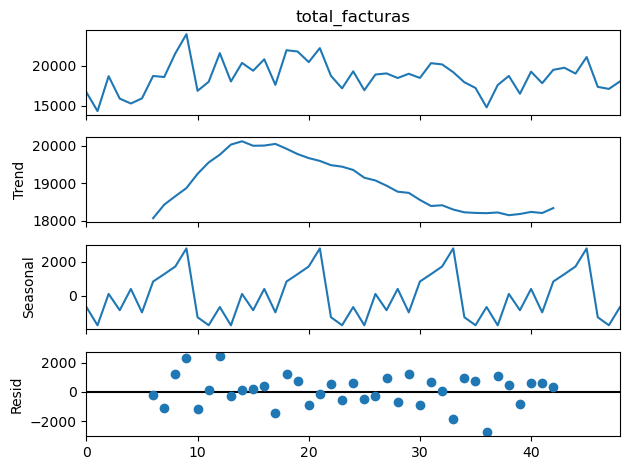

In [147]:
result = seasonal_decompose(data['total_facturas'], model='additive', period=12)
result.plot()
plt.show()

**Interpretación**

- Se puede ver que hay una tendencia ascendente con un descenso en los últimos periodos, con una leve recuperación en los últimos periodos.
- Se pude identificar que hay una clara estacionalidad en la serie, según lo visto en **seasonal**
- Los residuos se ven relativamente balanceados alrededor de cero, lo cual es bueno.
- No parecen tener un patrón claro → es una señal positiva de que el modelo capturó bien tendencia y estacionalidad.
- Si los residuos tuvieran un patrón claro (ej. tendencia, autocorrelación), indicaría que algo importante quedó sin capturar.
- Se concluye que necesitaremos de un modelo que pueda capturar la estacionalidad del modelo: SARIMA en lugar el ARIMA clásico.

# 3. Modelo

In [152]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import het_arch
from arch import arch_model
from pmdarima import auto_arima

In [150]:
serie = data['total_facturas']

In [153]:
modelo_sarima = auto_arima(
    serie,
    seasonal=True,
    m=12,           # ajusta s = número de períodos (aquí 12 si es mensual)
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=887.230, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=885.080, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1105.534, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=885.324, Time=0.06 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=886.830, Time=0.19 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=886.864, Time=0.11 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=888.620, Time=0.15 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=886.990, Time=0.04 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=884.893, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=886.045, Time=0.03 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=886.259, Time=0.29 sec
 ARIMA(1,0,1)(0,0,2)[12] intercept   : AIC=8

P-valor del test ARCH: 0.2906215759531013
P-valor mayor a 0.05. No hay heterocedasticidad


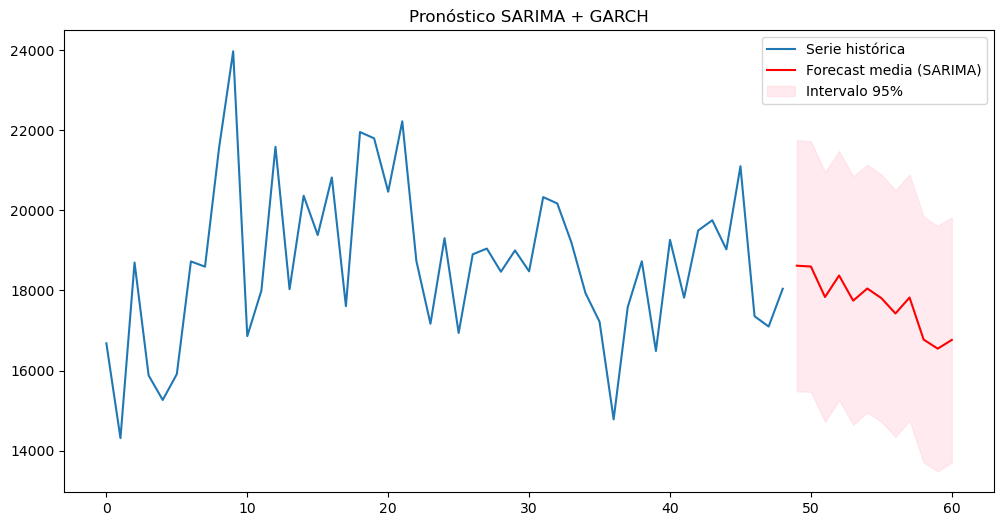

In [159]:
# 4. Ajustar el SARIMA definitivo con los parámetros encontrados
modelo_final = SARIMAX(
    serie,
    order=modelo_sarima.order,
    seasonal_order=modelo_sarima.seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)
resultado_sarima = modelo_final.fit(disp=False)

# 5. Obtener los residuos del SARIMA
residuos = resultado_sarima.resid

# 6. Verificar heterocedasticidad en residuos
p_arch = het_arch(residuos)[1]
print(f"P-valor del test ARCH: {p_arch}")

if p_arch < 0.05:
    print(f"P-valor menor a 0.05. Sí hay heterocedasticidad")
else:
    print(f"P-valor mayor a 0.05. No hay heterocedasticidad")

# Opcional: si p_arch < 0.05, hay heterocedasticidad

# 7. Ajustar un modelo GARCH sobre los residuos
modelo_garch = arch_model(residuos, vol='Garch', p=1, q=1)
resultado_garch = modelo_garch.fit(disp='off')

# 8. Predicciones

# Predicción del SARIMA (media)
forecast_sarima = resultado_sarima.get_forecast(steps=12)
prediccion_media = forecast_sarima.predicted_mean
intervalo_confianza_media = forecast_sarima.conf_int()

# Predicción de volatilidad futura con GARCH (varianza)
forecast_garch = resultado_garch.forecast(horizon=12)
prediccion_varianza = forecast_garch.variance.values[-1, :]

# 9. Graficar los resultados
plt.figure(figsize=(12, 6))

# Serie real
plt.plot(serie, label='Serie histórica')

# Predicción media
plt.plot(prediccion_media.index, prediccion_media.values, color='red', label='Forecast media (SARIMA)')

# Banda de confianza considerando la volatilidad estimada
conf_int_upper = prediccion_media + 1.96 * np.sqrt(prediccion_varianza)
conf_int_lower = prediccion_media - 1.96 * np.sqrt(prediccion_varianza)

plt.fill_between(prediccion_media.index, conf_int_lower, conf_int_upper, color='pink', alpha=0.3, label='Intervalo 95%')

plt.title('Pronóstico SARIMA + GARCH')
plt.legend()
plt.show()

In [163]:
modelo_sarima.seasonal_order

(0, 0, 1, 12)

# Validación - TimeSeriesSplit

In [160]:
from sklearn.model_selection import TimeSeriesSplit

# Suponiendo que 'serie' es tu serie de tiempo
X = np.arange(len(data['total_facturas']))  # Solo los índices, porque el modelo SARIMA trabaja con valores secuenciales
y = data['total_facturas'].values           # Tus valores reales

# Definir el splitter
tscv = TimeSeriesSplit(n_splits=5)  # Puedes cambiar el número de folds

# Visualizar cómo se hacen los splits
for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    print(f"Fold {fold+1}")
    print(f"Train indices: {train_idx}")
    print(f"Test indices: {test_idx}")
    print("-"*30)

Fold 1
Train indices: [0 1 2 3 4 5 6 7 8]
Test indices: [ 9 10 11 12 13 14 15 16]
------------------------------
Fold 2
Train indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Test indices: [17 18 19 20 21 22 23 24]
------------------------------
Fold 3
Train indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
Test indices: [25 26 27 28 29 30 31 32]
------------------------------
Fold 4
Train indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32]
Test indices: [33 34 35 36 37 38 39 40]
------------------------------
Fold 5
Train indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]
Test indices: [41 42 43 44 45 46 47 48]
------------------------------


In [166]:
errores = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    train, test = serie.iloc[train_idx], serie.iloc[test_idx]

    # Ajustar el modelo SARIMA en el set de entrenamiento
    modelo = SARIMAX(
        train,
        order=modelo_sarima.order,
        seasonal_order=modelo_sarima.seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    resultado = modelo.fit(disp=False)

    # Forecast sobre el período de test
    forecast = resultado.forecast(steps=len(test))

    # Calcular el error (puedes usar RMSE, MAE, MAPE, etc)
    error_fold = np.sqrt(np.mean((forecast - test)**2))  # RMSE
    errores.append(error_fold)

    print(f"Fold {fold+1} - RMSE: {error_fold:.2f}")

prom_rmse = np.mean(errores)

Fold 1 - RMSE: 5583.66
Fold 2 - RMSE: 3399.58
Fold 3 - RMSE: 4002.47
Fold 4 - RMSE: 1893.07
Fold 5 - RMSE: 11028.00


In [168]:
print(f"RMSE promedio de todos los folds: {prom_rmse:.2f}")

RMSE promedio de todos los folds: 5181.35


Un RMSE cercano al 20-25% del valor medio de la serie es generalmente aceptable en forecasting económico o de demanda.

In [171]:
prom_rmse / data['total_facturas'].mean()

0.2771533892037549

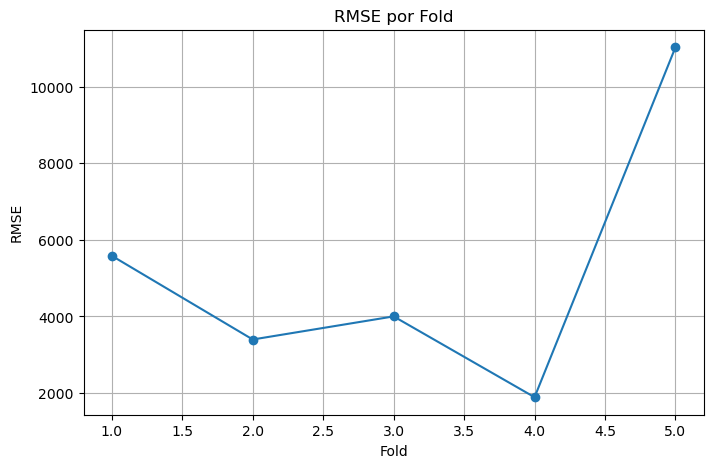

In [172]:
plt.figure(figsize=(8,5))
plt.plot(range(1, len(errores)+1), errores, marker='o')
plt.title('RMSE por Fold')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.grid()
plt.show()

Haciendo la validación con TimeSeriesSplit, podemos notar de que en el 5to fold, el RMSE se dispara.

Esto se puede interpretar como que el modelo no interpreta bien los periodos más actuales. Esto puede darse porque hay tendencias con las que se ha entrenado que ya no son válidas en periodos más recientes.

### Rolling Window

**Rolling Window** es una técnica para entrenar modelos de series de tiempo tomando solo los últimos periodos. Eso nos permite ignorar alguna tendencia que ya no es aplicable a los nuevos periodos.

In [202]:
# Para nuestro Rolling Window tomaremos los últimos 24 periodos (2 años)
periodos_rw = 24

train = serie.iloc[train_idx]
if len(train) > periodos_rw:
    train = train[-periodos_rw:]  # cortar solo los más recientes

# Luego ajustas el SARIMA normalmente
modelo_sarimax_rw = SARIMAX(
    train,
    order=(1,0,0),
    seasonal_order=(1,0,0,12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
resultado_sarimax_rw = modelo.fit(disp=False)

In [194]:
len(train)

24

In [ ]:
# Parámetros
periodos_rw = 24  # Últimos 24 periodos
n_splits = 2  # Número de folds que quieras probar

# Inicializar
tscv = TimeSeriesSplit(n_splits=n_splits)
errores = []

# Serie completa
serie = data['total_facturas']

for fold, (train_idx, test_idx) in enumerate(tscv.split(serie)):
    train, test = serie.iloc[train_idx], serie.iloc[test_idx]

    # Limitar el train a los últimos periodos_rw
    if len(train) > periodos_rw:
        train = train[-periodos_rw:]

    # Ajustar modelo EN CADA FOLD
    modelo = SARIMAX(
        train,
        order=(1,0,0),
        seasonal_order=(1,0,0,12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    resultado = modelo.fit(disp=False)

    # Forecast sobre el período de test
    forecast = resultado.forecast(steps=len(test))

    # Calcular error (RMSE en este caso)
    error_fold = np.sqrt(np.mean((forecast - test)**2))
    errores.append(error_fold)

    print(f"Fold {fold+1} - RMSE: {error_fold:.2f}")

# Promedio de errores
prom_rmse = np.mean(errores)
print(f"\nRMSE promedio de todos los folds: {prom_rmse:.2f}")

# Para ver el RMSE relativo a la media de la serie
print(f"RMSE Promedio / Media de la Serie: {prom_rmse / serie.mean():.4f}")

Fold 1 - RMSE: 4013.22
Fold 2 - RMSE: 1533.74

RMSE promedio de todos los folds: 2773.48
RMSE Promedio / Media de la Serie: 0.1484


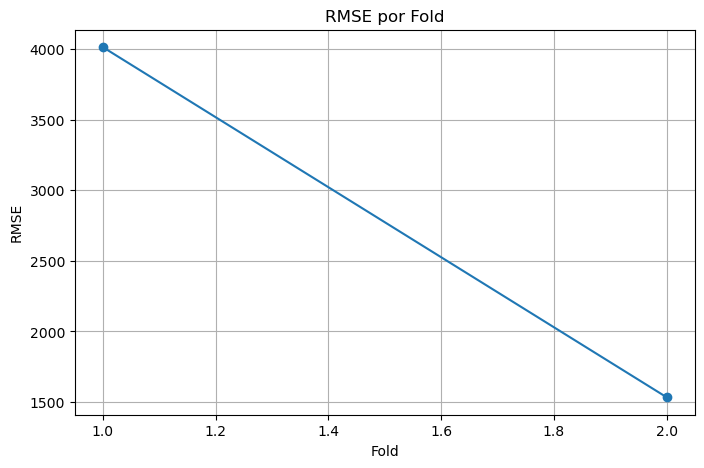

In [200]:
plt.figure(figsize=(8,5))
plt.plot(range(1, len(errores)+1), errores, marker='o')
plt.title('RMSE por Fold')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.grid()
plt.show()

In [203]:
print(resultado_sarimax_rw.summary())

                                     SARIMAX Results                                      
Dep. Variable:                     total_facturas   No. Observations:                   24
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood                 -94.858
Date:                            Sun, 27 Apr 2025   AIC                            195.716
Time:                                    20:33:13   BIC                            196.910
Sample:                                         0   HQIC                           194.964
                                             - 24                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9867      0.034     29.387      0.000       0.921       1.052
ar.S.L12       0.3268      0.135   

- Ljung-Box (Q): p-valor 0.07 → aceptable (no hay mucha autocorrelación).
- Jarque-Bera (JB): p-valor 0.67 → residuos normales.
- Heteroskedasticidad: p-valor 0.69 → residuos homogéneos.

¡Los residuos son razonablemente ruido blanco! ✔️

# Forecast

**Diferencia Clave**
- Ver qué tan bien el modelo explica mis datos pasados:	**predict()**
- Predecir meses futuros que todavía no han pasado:	**get_forecast(steps=...)**

In [204]:
# Predecir los próximos 12 pasos (12 meses)
forecast = resultado_sarimax_rw.get_forecast(steps=12)

# Obtener el intervalo de confianza
forecast_ci = forecast.conf_int()

# Mostrar predicciones
print(forecast.predicted_mean)

24    20564.890181
25    19248.493551
26    18561.564809
27    19086.736541
28    18143.657822
29    18617.187585
30    18498.199460
31    18145.804291
32    18158.322552
33    17828.227963
34    18277.030289
35    18070.099434
Name: predicted_mean, dtype: float64


In [208]:
# Predecir los próximos 12 pasos (12 meses)
forecast = resultado_sarimax_rw.get_forecast(steps=12)

# Obtener el intervalo de confianza
forecast_ci = forecast.conf_int()

# Obtener la predicción puntual
prediccion_central = forecast.predicted_mean

# Mostrar predicciones
print(prediccion_central)

# Obtener límites del intervalo de confianza
pesimista = forecast_ci.iloc[:, 0]  # límite inferior
optimista = forecast_ci.iloc[:, 1]  # límite superior

# Crear un DataFrame juntando todo
df_forecast = pd.DataFrame({
    'Pesimista': pesimista,
    'Predicción': prediccion_central,
    'Optimista': optimista
})

# Mostrarlo
print(df_forecast)

24    20564.890181
25    19248.493551
26    18561.564809
27    19086.736541
28    18143.657822
29    18617.187585
30    18498.199460
31    18145.804291
32    18158.322552
33    17828.227963
34    18277.030289
35    18070.099434
Name: predicted_mean, dtype: float64
       Pesimista    Predicción     Optimista
24  17927.766150  20564.890181  23202.014211
25  15543.793486  19248.493551  22953.193615
26  14054.236462  18561.564809  23068.893156
27  13916.360963  19086.736541  24257.112119
28  12400.858579  18143.657822  23886.457065
29  12367.277070  18617.187585  24867.098099
30  11791.331815  18498.199460  25205.067105
31  11022.176073  18145.804291  25269.432508
32  10651.156366  18158.322552  25665.488738
33   9965.626232  17828.227963  25690.829694
34  10083.197577  18277.030289  26470.863001
35   9566.186466  18070.099434  26574.012403


# Holt-Winters

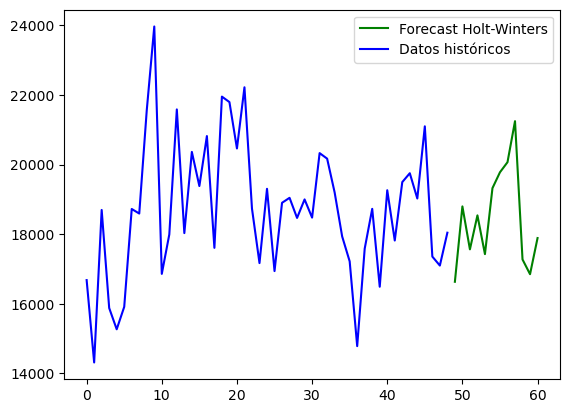

In [206]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Ajustar Holt-Winters
modelo_hw = ExponentialSmoothing(
    data['total_facturas'],
    trend='add',            # Tendencia aditiva
    seasonal='add',         # Estacionalidad aditiva
    seasonal_periods=12     # Estacionalidad anual (12 si es mensual)
)

resultado_hw = modelo_hw.fit()

# Forecast para los próximos 12 meses
forecast_hw = resultado_hw.forecast(steps=12)

forecast_hw.plot(label='Forecast Holt-Winters', color='green')
data['total_facturas'].plot(label='Datos históricos', color='blue')
plt.legend()
plt.show()

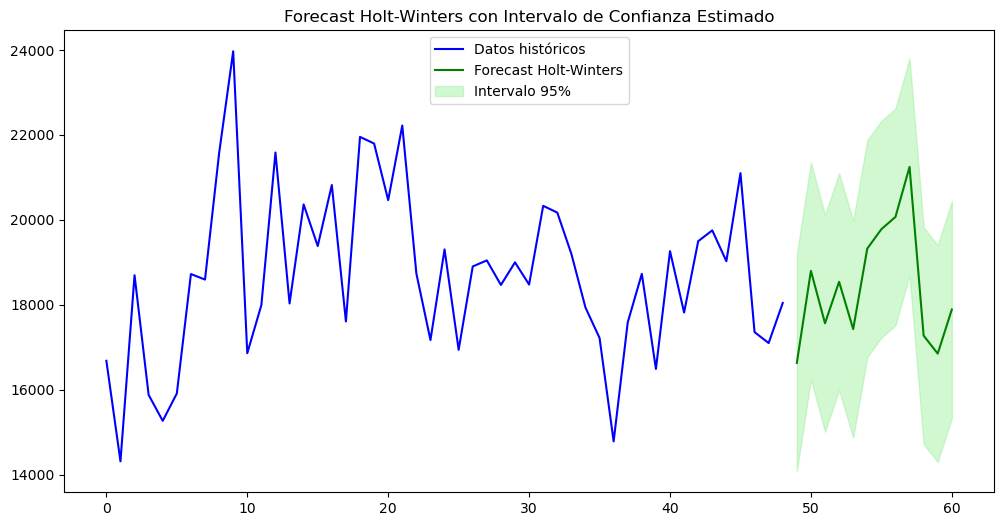

In [212]:
# Calcular residuos
residuos = resultado_hw.resid

# Desviación estándar de los residuos
std_residuos = np.std(residuos)

# Construir bandas de confianza (por ejemplo, 1.96 * std para 95%)
confianza = 1.96

# Pesimista y optimista
pesimista = forecast_hw - confianza * std_residuos
optimista = forecast_hw + confianza * std_residuos

# Graficar
plt.figure(figsize=(12,6))
plt.plot(data['total_facturas'], label='Datos históricos', color='blue')
plt.plot(forecast_hw, label='Forecast Holt-Winters', color='green')
plt.fill_between(forecast_hw.index, pesimista, optimista, color='lightgreen', alpha=0.4, label='Intervalo 95%')
plt.legend()
plt.title('Forecast Holt-Winters con Intervalo de Confianza Estimado')
plt.show()

# XGBoost

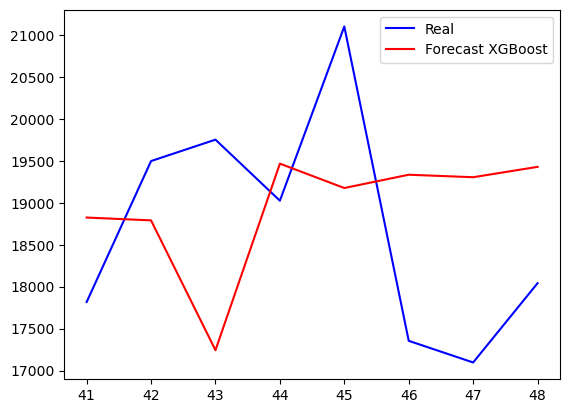

In [ ]:
# Crear variables lag
def crear_lags(serie, lags=[1,2,3,12]):
    df = pd.DataFrame({'y': serie})
    for lag in lags:
        df[f'lag_{lag}'] = serie.shift(lag)
    df = df.dropna()
    return df

df_lags = crear_lags(data['total_facturas'])

X = df_lags.drop(columns=['y'])
y = df_lags['y']

# Separar train/test
train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Entrenar modelo XGBoost
modelo_xgb = xgb.XGBRegressor(n_estimators=100)
modelo_xgb.fit(X_train, y_train)

# Predecir
forecast_xgb = modelo_xgb.predict(X_test)

# Graficar resultados
plt.plot(y_test.index, y_test, label='Real', color='blue')
plt.plot(y_test.index, forecast_xgb, label='Forecast XGBoost', color='red')
plt.legend()
plt.show()